In [1]:
# Load the credit dataset
credit <- read.csv("credit.csv", stringsAsFactors = TRUE)

# Display the new structure
str(credit)

'data.frame':	1000 obs. of  17 variables:
 $ checking_balance    : Factor w/ 4 levels "< 0 DM","> 200 DM",..: 1 3 4 1 1 4 4 3 4 3 ...
 $ months_loan_duration: int  6 48 12 42 24 36 24 36 12 30 ...
 $ credit_history      : Factor w/ 5 levels "critical","good",..: 1 2 1 2 4 2 2 2 2 1 ...
 $ purpose             : Factor w/ 6 levels "business","car",..: 5 5 4 5 2 4 5 2 5 2 ...
 $ amount              : int  1169 5951 2096 7882 4870 9055 2835 6948 3059 5234 ...
 $ savings_balance     : Factor w/ 5 levels "< 100 DM","> 1000 DM",..: 5 1 1 1 1 5 4 1 2 1 ...
 $ employment_duration : Factor w/ 5 levels "< 1 year","> 7 years",..: 2 3 4 4 3 3 2 3 4 5 ...
 $ percent_of_income   : int  4 2 2 2 3 2 3 2 2 4 ...
 $ years_at_residence  : int  4 2 3 4 4 4 4 2 4 2 ...
 $ age                 : int  67 22 49 45 53 35 53 35 61 28 ...
 $ other_credit        : Factor w/ 3 levels "bank","none",..: 2 2 2 2 2 2 2 2 2 2 ...
 $ housing             : Factor w/ 3 levels "other","own",..: 2 2 2 1 1 1 2 3 2 2 ...
 $ exi

In [2]:
# Re-level 'default' so that 'yes' comes first, 'no' comes second
credit$default <- factor(credit$default, levels = c("yes", "no"))

In [3]:
# Load the package "caret"
library(caret)

# Set up a control object for training
xgb_ctrl <- trainControl(method = "cv",
                         number = 10,
                         selectionFunction = "best",
                         summaryFunction = twoClassSummary,
                         classProbs = TRUE,
                         savePredictions = TRUE,
                         returnData = FALSE
                        )

Loading required package: ggplot2

Loading required package: lattice



In [4]:
# Set seed for reproducibility
set.seed(2023) 

# Train the model
xgb_model <- train(default ~ .,
                   data = credit,
                   trControl = xgb_ctrl,
                   method = "xgbTree",
                   metric = "ROC",
                   verbosity = 0
                  )

# Display basic model information
xgb_model

eXtreme Gradient Boosting 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 900, 900, 900, 900, 900, 900, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  ROC        Sens     
  0.3  1          0.6               0.50        50      0.7569286  0.3666667
  0.3  1          0.6               0.50       100      0.7692857  0.4166667
  0.3  1          0.6               0.50       150      0.7661429  0.4400000
  0.3  1          0.6               0.75        50      0.7649286  0.3733333
  0.3  1          0.6               0.75       100      0.7693333  0.3966667
  0.3  1          0.6               0.75       150      0.7640000  0.4233333
  0.3  1          0.6               1.00        50      0.7580714  0.3066667
  0.3  1          0.6               1.00       100      0.7682857  0.3900000
  0.3  1          0.6               1.00       150      0.7680476  0.3933333
  0.3  1          0.8               0.5

In [5]:
# Display the best AUC
max(xgb_model$results$ROC)

# Display the final tuned values
xgb_model$bestTune

# Display all those metrics for which AUC is maximum (they are in xgb_model$results)
xgb_model$results[xgb_model$results$ROC == max(xgb_model$results$ROC), ]

[1] 0.7805714

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43,50,3,0.3,0,0.6,1,1


,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
43,0.3,3,0,0.6,1,1,50,0.7805714,0.4766667,0.8714286,0.05870433,0.04727122,0.04809288


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Setting direction: controls < cases



Area under the curve: 0.7591

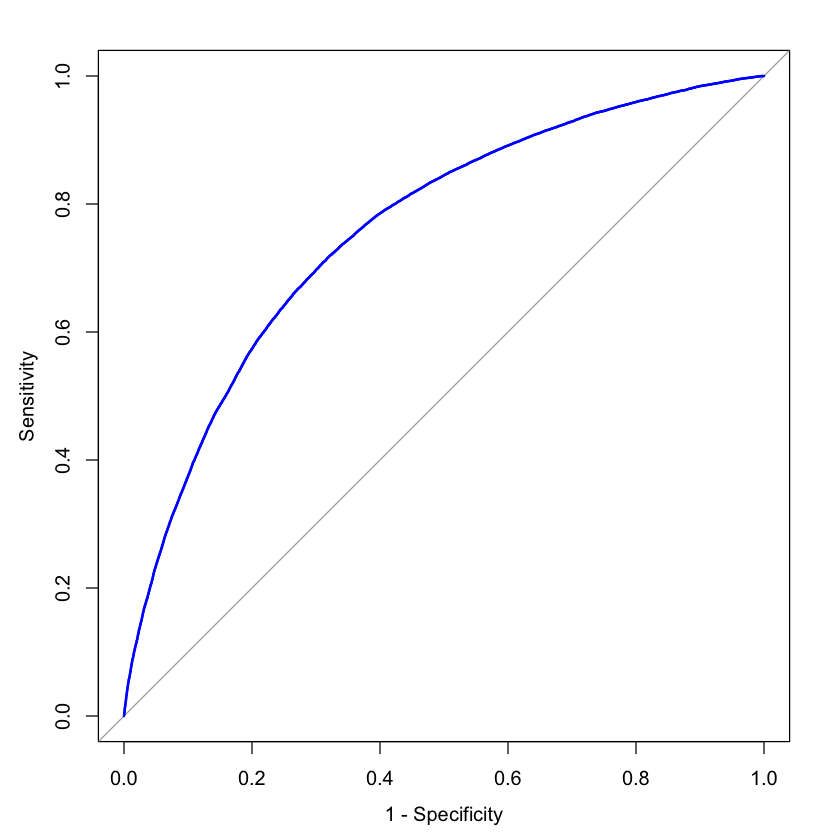

In [6]:
# Load the package for ROC curve
library(pROC)

# Generate the ROC object from all of the model observations and all of the predictions (over all parameter values)
credit_roc <- roc(response = xgb_model$pred$obs, predictor = xgb_model$pred$yes, levels = c("no", "yes"))

# Plot the ROC curve
plot(credit_roc, col = "blue", lwd = 2, legacy.axes = TRUE)

# Display the AUC
credit_roc$auc

In [7]:
# Generate prediction with the final model and the training data
credit_pred <- predict(xgb_model, credit)

# Display the confusion matrix and other information
confusionMatrix(data = credit_pred, reference = credit$default, positive = "yes")

Confusion Matrix and Statistics

          Reference
Prediction yes  no
       yes 207  27
       no   93 673
                                          
               Accuracy : 0.88            
                 95% CI : (0.8582, 0.8995)
    No Information Rate : 0.7             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.6951          
                                          
 Mcnemar's Test P-Value : 2.963e-09       
                                          
            Sensitivity : 0.6900          
            Specificity : 0.9614          
         Pos Pred Value : 0.8846          
         Neg Pred Value : 0.8786          
             Prevalence : 0.3000          
         Detection Rate : 0.2070          
   Detection Prevalence : 0.2340          
      Balanced Accuracy : 0.8257          
                                          
       'Positive' Class : yes             
                              

Setting direction: controls < cases



Area under the curve: 0.9401

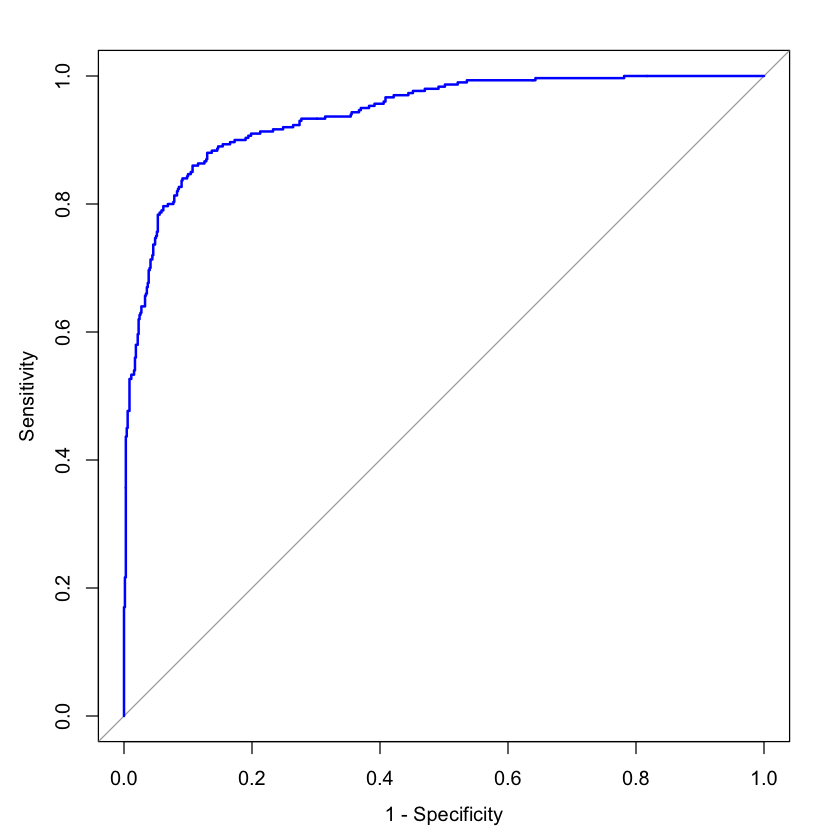

In [8]:
# Generate probabilities prediction with the final model and the training data
credit_pred_prob <- predict(xgb_model, credit, type = "prob")

# Generate the ROC object
credit_roc <- roc(response = credit$default, predictor = credit_pred_prob$yes, levels = c("no", "yes"))

# Plot the ROC curve
plot(credit_roc, col = "blue", lwd = 2, legacy.axes = TRUE)

# Display the AUC
credit_roc$auc

In [9]:
# Set up a control object for training
xgb_ctrl <- trainControl(method = "cv",
                         number = 10,
                         selectionFunction = "best",
                         summaryFunction = twoClassSummary,
                         classProbs = TRUE,
                         savePredictions = TRUE,
                         returnData = FALSE
                        )

# Set up a grid with all combinations of the chosen parameter values
grid <- expand.grid(eta = c(0.2, 0.3, 0.4),
                    max_depth = c(2, 3, 4),
                    gamma = c(0, 1),
                    colsample_bytree = c(0.7, 0.8, 0.9),
                    min_child_weight = 1,
                    subsample = c(0.7, 0.75, 0.8),
                    nrounds = c(25, 50, 75, 100)
                   )

# Set seed for reproducibility
set.seed(2023) 

# Train the model
xgb_model <- train(default ~ .,
                   data = credit,  
                   trControl = xgb_ctrl,
                   tuneGrid = grid,
                   method = "xgbTree",
                   metric = "ROC",
                   verbosity = 0
                  )

# Display the best ROC
max(xgb_model$results$ROC)

# Display the final tuned values
xgb_model$bestTune

# Display all those metrics for which ROC is maximum (they are in xgb_model$results)
xgb_model$results[xgb_model$results$ROC == max(xgb_model$results$ROC), ]

[1] 0.7907619

,nrounds,max_depth,eta,gamma,colsample_bytree,min_child_weight,subsample
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
179,75,4,0.2,0,0.9,1,0.8


,eta,max_depth,gamma,colsample_bytree,min_child_weight,subsample,nrounds,ROC,Sens,Spec,ROCSD,SensSD,SpecSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
179,0.2,4,0,0.9,1,0.8,75,0.7907619,0.4866667,0.8671429,0.05808448,0.07568616,0.05218578


Setting direction: controls < cases



Area under the curve: 0.765

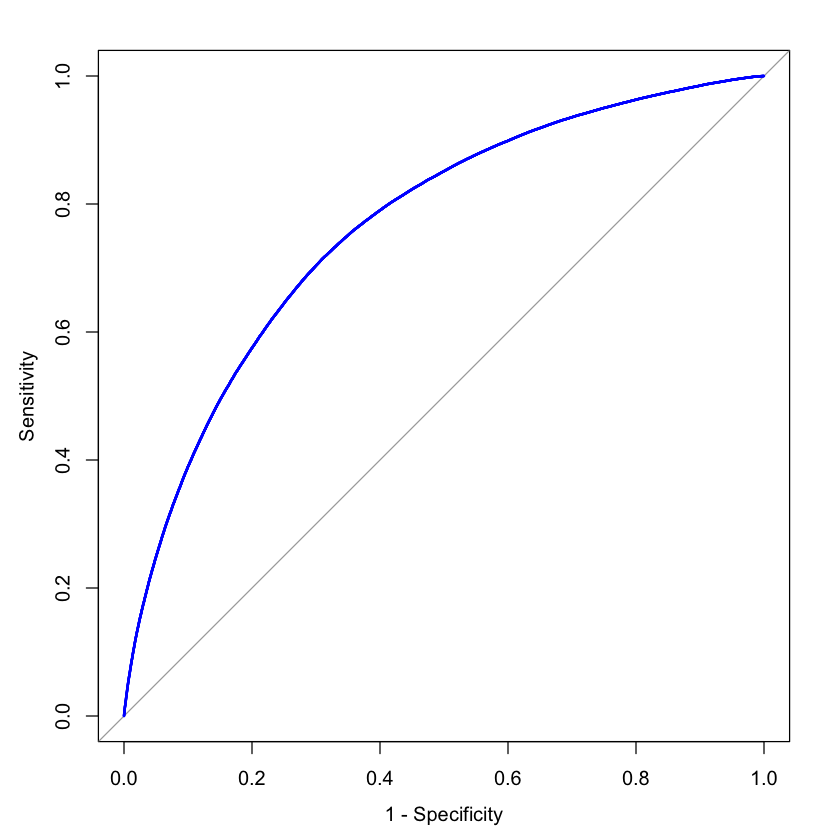

In [10]:
# Generate the ROC object from all of the model observations and all of the predictions (over all parameter values)
credit_roc <- roc(response = xgb_model$pred$obs, predictor = xgb_model$pred$yes, levels = c("no", "yes"))

# Plot the ROC curve
plot(credit_roc, col = "blue", lwd = 2, legacy.axes = TRUE)

# Display the AUC
credit_roc$auc

In [11]:
# Generate prediction with the final model and the training data
credit_pred <- predict(xgb_model, credit)

# Display the confusion matrix and other information
confusionMatrix(data = credit_pred, reference = credit$default, positive = "yes")

Confusion Matrix and Statistics

          Reference
Prediction yes  no
       yes 254  15
       no   46 685
                                         
               Accuracy : 0.939          
                 95% CI : (0.9223, 0.953)
    No Information Rate : 0.7            
    P-Value [Acc > NIR] : < 2.2e-16      
                                         
                  Kappa : 0.8503         
                                         
 Mcnemar's Test P-Value : 0.0001225      
                                         
            Sensitivity : 0.8467         
            Specificity : 0.9786         
         Pos Pred Value : 0.9442         
         Neg Pred Value : 0.9371         
             Prevalence : 0.3000         
         Detection Rate : 0.2540         
   Detection Prevalence : 0.2690         
      Balanced Accuracy : 0.9126         
                                         
       'Positive' Class : yes            
                                         

Setting direction: controls < cases



Area under the curve: 0.9867

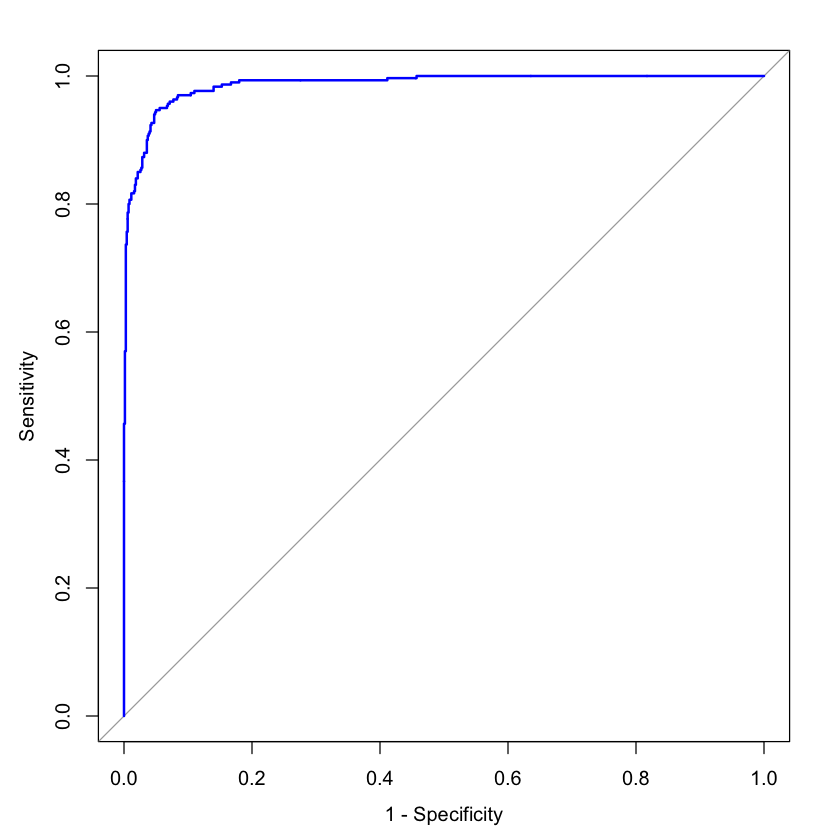

In [12]:
# Generate probabilities prediction with the final model and the training data
credit_pred_prob <- predict(xgb_model, credit, type = "prob")

# Generate the ROC object from all of the model observations and all of the predictions (over all parameter values)
credit_roc <- roc(response = credit$default, predictor = credit_pred_prob$yes, levels = c("no", "yes"))

# Plot the ROC curve
plot(credit_roc, col = "blue", lwd = 2, legacy.axes = TRUE)

# Display the AUC
credit_roc$auc